# Celltype Prediction

We get the data from the Marioni, see the "1_prime_the_data.ipynb" notebook.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas

In [2]:
raw_dataset = pandas.read_csv("celltype_prediction_test.tsv", delimiter="\t")

In [3]:
raw_dataset

,nCount_RNA,nFeature_RNA,Apoa1,Rbp4,Ttr,Spink1,Apom,Apoe,Dkk1,Ctsl,...,Erbb2,Nptx2,0610012G03Rik,Lypd1,3110021N24Rik,Pdzd3,Efemp1,Foxa1,Ripply3,Celltype
0,8010,2391,0,0,0,0,0,2,0,1,...,0,0,2,0,0,0,0,0,0,Epiblast
1,6122,2087,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,Epiblast
2,10022,2809,0,0,0,0,0,4,0,4,...,0,0,1,0,0,0,0,0,0,Epiblast
3,8759,2429,0,1,0,0,0,0,0,3,...,0,0,1,0,0,0,0,0,0,Epiblast
4,5718,2014,0,0,0,0,0,3,0,2,...,0,0,1,0,0,0,0,0,0,Epiblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,12273,3221,0,0,0,0,0,4,0,4,...,1,0,3,0,0,0,0,0,0,ExE ectoderm
2071,8347,2549,0,0,0,1,0,15,0,3,...,0,0,2,0,0,0,0,0,0,ExE ectoderm
2072,9364,2734,2,0,0,0,0,5,0,3,...,0,0,2,0,0,0,0,0,0,ExE ectoderm
2073,7918,2302,0,0,1,0,0,0,0,2,...,0,0,3,0,0,0,0,0,0,Anterior Primitive Streak


We now need to convert this into a pure integer dataset, which means assigning the celltypes to specific numbers.

In [4]:
ctypes = raw_dataset["Celltype"].unique().tolist()
ctypes_int = {x : ctypes[x] for x in range(len(ctypes))}
print("Int → Celltype")
print(ctypes_int)
ctypes_name = {y : x for x,y in ctypes_int.items()}
print("\nCelltype → Int")
print(ctypes_name)

Int → Celltype
{0: 'Epiblast', 1: 'Primitive Streak', 2: 'ExE endoderm', 3: 'Visceral endoderm', 4: 'ExE ectoderm', 5: 'Nascent mesoderm', 6: 'Anterior Primitive Streak', 7: 'PGC', 8: 'Mixed mesoderm', 9: 'Rostral neurectoderm', 10: 'Surface ectoderm', 11: 'Def. endoderm', 12: 'Haematoendothelial progenitors'}

Celltype → Int
{'Epiblast': 0, 'Primitive Streak': 1, 'ExE endoderm': 2, 'Visceral endoderm': 3, 'ExE ectoderm': 4, 'Nascent mesoderm': 5, 'Anterior Primitive Streak': 6, 'PGC': 7, 'Mixed mesoderm': 8, 'Rostral neurectoderm': 9, 'Surface ectoderm': 10, 'Def. endoderm': 11, 'Haematoendothelial progenitors': 12}


and now to replace this in the actual dataset

In [5]:
print(raw_dataset["Celltype"])
raw_dataset["Celltype"] = raw_dataset["Celltype"].map(lambda x: ctypes_name[x])
print(raw_dataset["Celltype"])

0                        Epiblast
1                        Epiblast
2                        Epiblast
3                        Epiblast
4                        Epiblast
                  ...            
2070                 ExE ectoderm
2071                 ExE ectoderm
2072                 ExE ectoderm
2073    Anterior Primitive Streak
2074                     Epiblast
Name: Celltype, Length: 2075, dtype: object
0       0
1       0
2       0
3       0
4       0
       ..
2070    4
2071    4
2072    4
2073    6
2074    0
Name: Celltype, Length: 2075, dtype: int64


Okay, so now we have a pure integer matrix!

In [6]:
raw_dataset = raw_dataset.astype("int")

## Split into input and output variables

In [7]:
raw_dataset

,nCount_RNA,nFeature_RNA,Apoa1,Rbp4,Ttr,Spink1,Apom,Apoe,Dkk1,Ctsl,...,Erbb2,Nptx2,0610012G03Rik,Lypd1,3110021N24Rik,Pdzd3,Efemp1,Foxa1,Ripply3,Celltype
0,8010,2391,0,0,0,0,0,2,0,1,...,0,0,2,0,0,0,0,0,0,0
1,6122,2087,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10022,2809,0,0,0,0,0,4,0,4,...,0,0,1,0,0,0,0,0,0,0
3,8759,2429,0,1,0,0,0,0,0,3,...,0,0,1,0,0,0,0,0,0,0
4,5718,2014,0,0,0,0,0,3,0,2,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,12273,3221,0,0,0,0,0,4,0,4,...,1,0,3,0,0,0,0,0,0,4
2071,8347,2549,0,0,0,1,0,15,0,3,...,0,0,2,0,0,0,0,0,0,4
2072,9364,2734,2,0,0,0,0,5,0,3,...,0,0,2,0,0,0,0,0,0,4
2073,7918,2302,0,0,1,0,0,0,0,2,...,0,0,3,0,0,0,0,0,0,6


In [8]:
dataset = raw_dataset.to_numpy()
dataset

array([[ 8010,  2391,     0, ...,     0,     0,     0],
       [ 6122,  2087,     1, ...,     0,     0,     0],
       [10022,  2809,     0, ...,     0,     0,     0],
       ...,
       [ 9364,  2734,     2, ...,     0,     0,     4],
       [ 7918,  2302,     0, ...,     0,     0,     6],
       [10138,  2451,     0, ...,     0,     0,     0]])

In [9]:
X = dataset[:,:-1]   ## metadata and 2000 genes
y = dataset[:,-1]    ## celltype prediction

In [10]:
y

array([0, 0, 0, ..., 4, 6, 0])

Finally, because the output sigmoid function is between 0 and 1, we need to standardize the predictor into that space.

In [11]:
def min_max_scale(arr, new_min=0, new_max=1):
    min_val = np.min(arr)
    max_val = np.max(arr)
    scaled = (arr - min_val) / (max_val - min_val) * (new_max - new_min) + new_min
    return scaled

min_max_scale(y)

array([0.        , 0.        , 0.        , ..., 0.33333333, 0.5       ,
       0.        ])

In [12]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(min_max_scale(y), dtype=torch.float32).reshape(-1, 1)

2002

In [13]:
# define the model
class CellTypeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2002, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x

model = CellTypeClassifier()
print(model)

CellTypeClassifier(
  (hidden1): Linear(in_features=2002, out_features=12, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=12, out_features=8, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (act_output): Sigmoid()
)


In [14]:
# train the model
loss_fn   = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 1000

Loss = [] 

for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        Loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}', end="\r")

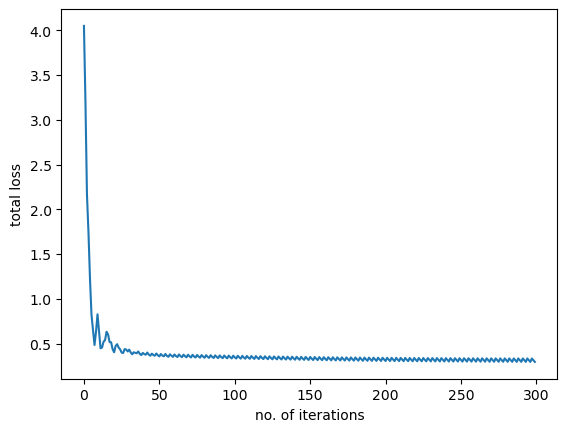

In [20]:
import matplotlib.pyplot as plt

plt.plot(Loss)
plt.xlabel("no. of iterations")
plt.ylabel("total loss")
plt.show()

# Make Celltype Prediction on trained model

We will generate a pseudo celltype from a given known celltype, using the mean expression of the genes and meta data in the data, and see if it outputs the right celltype prediction.

In [23]:
[x for x in raw_dataset["Celltype"] == ctypes_name["Rostral neurectoderm"] if x == True]

[True, True]

In [16]:
## Mixed mesoderm "8"
def makePseudoCell(name):
    ## Filter by a type and apply the mean, then remove the celltype
    ps = raw_dataset[
        raw_dataset["Celltype"] == ctypes_name[name]
    ].apply(np.mean).round().drop("Celltype")
    ps.name = name
    return(ps)

def makeAllPseudoCells():
    df = pandas.DataFrame()
    for ctype in ctypes_name.keys():
        df = pandas.concat([df, makePseudoCell(ctype)], axis=1)
    return(df.T)        

print("Created Pseudoreference")
test_data = makeAllPseudoCells()
test_data

Created Pseudoreference


,nCount_RNA,nFeature_RNA,Apoa1,Rbp4,Ttr,Spink1,Apom,Apoe,Dkk1,Ctsl,...,Gpc6,Erbb2,Nptx2,0610012G03Rik,Lypd1,3110021N24Rik,Pdzd3,Efemp1,Foxa1,Ripply3
Epiblast,10512.0,2703.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Primitive Streak,10112.0,2650.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ExE endoderm,9992.0,2702.0,88.0,35.0,68.0,44.0,30.0,92.0,0.0,46.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Visceral endoderm,9314.0,2703.0,28.0,6.0,21.0,46.0,7.0,49.0,7.0,13.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ExE ectoderm,15190.0,3318.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,3.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Nascent mesoderm,9138.0,2506.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Anterior Primitive Streak,9602.0,2598.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
PGC,7752.0,2367.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mixed mesoderm,8126.0,2411.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Rostral neurectoderm,8162.0,2466.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
test_X = torch.tensor(test_data.to_numpy(), dtype=torch.float32)
print(X.shape)
print(test_X.shape)

torch.Size([2075, 2002])
torch.Size([13, 2002])


We have 13 test observations compared to the 2075 they were tested on.

In [19]:
# compute accuracy of training data
y_pred = model(X)
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

# make class predictions with the model
predictions = [ctypes_int[int(x[0])]
               for x in (model(test_X) * len(ctypes_int)).floor().tolist()]
df = pandas.DataFrame()
for i in range(len(test_data)):
    df = pandas.concat([
        df, 
        pandas.DataFrame({
            "Pseudo": test_data.iloc[i].name, 
            "Predicted": predictions[i]
        }, index=[0])], axis=0)
print(df)

Accuracy 0.4125301241874695
                           Pseudo                  Predicted
0                        Epiblast                   Epiblast
0                Primitive Streak                   Epiblast
0                    ExE endoderm           Primitive Streak
0               Visceral endoderm               ExE endoderm
0                    ExE ectoderm               ExE ectoderm
0                Nascent mesoderm               ExE ectoderm
0       Anterior Primitive Streak               ExE endoderm
0                             PGC               ExE ectoderm
0                  Mixed mesoderm  Anterior Primitive Streak
0            Rostral neurectoderm                   Epiblast
0                Surface ectoderm               ExE ectoderm
0                   Def. endoderm           Primitive Streak
0  Haematoendothelial progenitors               ExE ectoderm


Not the greatest.

Let's try brute force this to see whether it can be improved by changing the number of nodes in the layers.

# As a Library

Let's write up the above into a library called "CellTypePredictor" to automate some of this.

In [126]:
from importlib import reload
import CellTypePredictor as ctp

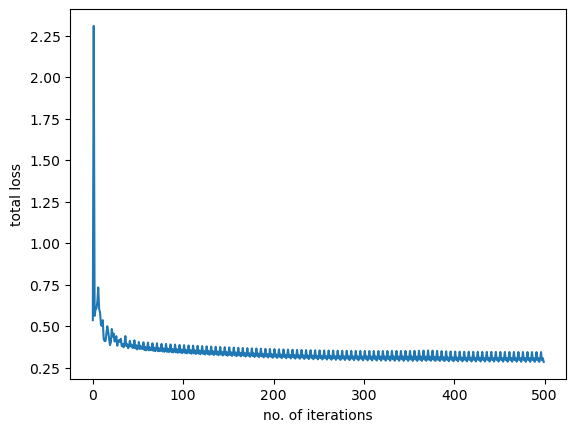

In [127]:
reload(ctp)
raw_dataset = pandas.read_csv("celltype_prediction_test.tsv", delimiter="\t")
ctpred = ctp.CellTypePrediction(raw_dataset, "Celltype", 
                         ((2002,12), (12,8), (8,1)),
                         n_epochs=100, batch_size=500, multiclass=False, lossplot = True)

In [128]:
test_dataset = ctpred.makePseudoCells()
test_dataset

Created 13  pseudo cells from the averages of cells in the same output group


,nCount_RNA,nFeature_RNA,Apoa1,Rbp4,Ttr,Spink1,Apom,Apoe,Dkk1,Ctsl,...,Gpc6,Erbb2,Nptx2,0610012G03Rik,Lypd1,3110021N24Rik,Pdzd3,Efemp1,Foxa1,Ripply3
Epiblast,10512.0,2703.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Primitive Streak,10112.0,2650.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ExE endoderm,9992.0,2702.0,88.0,35.0,68.0,44.0,30.0,92.0,0.0,46.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Visceral endoderm,9314.0,2703.0,28.0,6.0,21.0,46.0,7.0,49.0,7.0,13.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ExE ectoderm,15190.0,3318.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,3.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
Nascent mesoderm,9138.0,2506.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Anterior Primitive Streak,9602.0,2598.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
PGC,7752.0,2367.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mixed mesoderm,8126.0,2411.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Rostral neurectoderm,8162.0,2466.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
ctpred.determineAccuracy()

Mean Accuracy: 0.4125301241874695


0.4125301241874695

In [130]:
ctpred.doLabelPrediction(test_dataset)

{'score': 23,
 'result':                            Pseudo                  Predicted
 0                        Epiblast                   Epiblast
 0                Primitive Streak                   Epiblast
 0                    ExE endoderm           Primitive Streak
 0               Visceral endoderm               ExE endoderm
 0                    ExE ectoderm               ExE ectoderm
 0                Nascent mesoderm           Nascent mesoderm
 0       Anterior Primitive Streak          Visceral endoderm
 0                             PGC           Nascent mesoderm
 0                  Mixed mesoderm  Anterior Primitive Streak
 0            Rostral neurectoderm                   Epiblast
 0                Surface ectoderm           Nascent mesoderm
 0                   Def. endoderm               ExE endoderm
 0  Haematoendothelial progenitors           Nascent mesoderm}

## Parameter Search

We'll change some parameters to see if we can improve that prediction score

In [134]:
from importlib import reload
import CellTypePredictor as ctp
reload(ctp)
raw_dataset = pandas.read_csv("celltype_prediction_test.tsv", delimiter="\t")
ctpred = ctp.CellTypePrediction(
    raw_dataset, "Celltype", 
    ((2002,12), (12,8), (8,1)),
    n_epochs=100, batch_size=500, multiclass=False, lossplot=False)
test_dataset = ctpred.makePseudoCells(message=False) ## there should be an n-value here
mean_acc = ctpred.determineAccuracy(message=False)
do_pred = ctpred.doLabelPrediction(test_dataset)
print(do_pred)

{'score_perc': 23, 'result':                            Pseudo          Predicted
0                        Epiblast           Epiblast
0                Primitive Streak   Primitive Streak
0                    ExE endoderm       ExE endoderm
0               Visceral endoderm   Primitive Streak
0                    ExE ectoderm  Visceral endoderm
0                Nascent mesoderm   Primitive Streak
0       Anterior Primitive Streak   Primitive Streak
0                             PGC   Primitive Streak
0                  Mixed mesoderm   Primitive Streak
0            Rostral neurectoderm   Primitive Streak
0                Surface ectoderm   Primitive Streak
0                   Def. endoderm   Primitive Streak
0  Haematoendothelial progenitors   Primitive Streak}
